https://radimrehurek.com/gensim/models/word2vec.html

https://rare-technologies.com/word2vec-tutorial/

https://medium.com/plotly/understanding-word-embedding-arithmetic-why-theres-no-single-answer-to-king-man-woman-cd2760e2cb7f

In [1]:
%%time
import pandas as pd
import dataframe_image as dfi

import spacy

nlp = spacy.load("en_core_web_md")
nlp.add_pipe('merge_entities', after = 'ner')

display(pd.DataFrame({'spaCy pipeline components': nlp.pipe_names}).T)

,0,1,2,3,4,5,6
spaCy pipeline components,tok2vec,tagger,parser,attribute_ruler,lemmatizer,ner,merge_entities


CPU times: user 2.74 s, sys: 385 ms, total: 3.12 s
Wall time: 4.39 s


In [2]:
%%time

import datetime
import os

def get_dataset_dirpath(cwd):
    
    two_up = os.path.dirname(os.path.dirname(cwd))
    
    return os.path.join(two_up, 'dataset')

dataset_dirpath = get_dataset_dirpath(os.getcwd())

binladenpath = os.path.join(dataset_dirpath, 'Osama bin Laden/')
bushpath = os.path.join(dataset_dirpath, 'George Bush/')


Bush_FileList = [
    '20010914-Remarks at the National Day of Prayer & Remembrance Service.txt',
    '20010915-First Radio Address following 911.txt',
    '20010917-Address at Islamic Center of Washington, D.C..txt',
    '20010920-Address to Joint Session of Congress Following 911 Attacks.txt',
    '20010911-911 Address to the Nation.txt',
    '20011007-Operation Enduring Freedom in Afghanistan Address to the Nation.txt',
    '20011011-911 Pentagon Remembrance Address.txt',
    '20011011-Prime Time News Conference on War on Terror.txt',
    '20011026-Address on Signing the USA Patriot Act of 2001.txt',
    '20011110-First Address to the United Nations General Assembly.txt',
    '20011211-Address to Citadel Cadets.txt',
    '20011211-The World Will Always Remember 911.txt',
    '20020129-First (Official) Presidential State of the Union Address.txt'
]

text = ''

raw = ""
for file in Bush_FileList:
    with open(os.path.join(bushpath, file), 'r') as text:
        raw = raw + text.read()
        
print(f'doc length: {len(raw)}')

doc length: 111934
CPU times: user 1.04 ms, sys: 1.6 ms, total: 2.64 ms
Wall time: 3.61 ms


# Pre-Process text using spaCy

https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/

In [3]:
%%time
import json
import string
from typing import List
from spacy.symbols import GPE, NORP, ORG, PERSON

from gensim.models import Word2Vec

from abc import ABC

class create_doc_array(ABC):
    
    def __init__(self, doc = None, normalised_ents = None, algorithm = None):
        
        self.doc = doc
        self.normalised_ents = normalised_ents
        
        self.group_labels = [GPE, NORP, ORG, PERSON]
        
        vector_size = 500
        window = 5
        min_count=1
        sg = 1
        
        self.model = algorithm(sentences=list(self.sentences), vector_size=vector_size, window=window, min_count=min_count, sg=sg)
        self.wv = self.model.wv
        
    @property
    def group_ents(self):
        
        return set(
            [self.word_normalise(ent.text) for ent in self.doc.ents if ent.label in self.group_labels]
        )
        
    @property
    def sentences(self):
        return self.generate_doc_array()
    
    def __call__(self):
        return self.generate_doc_array()
    
    def most_similar(self, word, topn = None):
        if not topn:
            topn = 10
            
        word = self.word_transform(word)
        
        return self.wv.most_similar(word, topn=topn)
    
    def word_in_normalised_ents(self, word):
        
        if self.normalised_ents:
            
            return word.lower() in self.normalised_ents
        
        return False
    
    def word_normalise(self, word):
        
        word = word.lower()
        
        if self.word_in_normalised_ents(word):
            
            return self.normalised_ents[word]
        
        return word
    
    def word_transform(self, word):
        
        word = self.word_normalise(word)
        
        return word.lower().replace(" ", "_")
        
    def generate_doc_array(self):  

        for sent in self.doc.sents:

            sent_array = []

            for token in sent:

                if token.is_punct:
                    continue

                if token.is_stop:
                    continue

                if token.is_space:
                    continue

                if '\n' in token.text:
                    continue

                text = token.lemma_.lower()

                if self.word_in_normalised_ents(token.text):
                    
                    text = self.word_normalise(token.text).lower()

                text = text.replace(" ", "_")
                text = text.replace("the ", "")

                sent_array.append(text)

            yield sent_array
            
    def get_similar_terms(self, words):
    
        data = {}

        for word in words:

            if self.__contains__(word):
                
                word_transform = self.word_transform(word)
                
                data[word] = [f'{sim[0].title()}, ({round(sim[1], 3)})' for sim in self.most_similar(word_transform)]
            
            else:
                print(f'{word} not in vocab ({word_transform})')
                
                if self.in_array(word):
                    print(f'{word} in sentence array')
                else:
                    print(print(f'{word} not sentence array'))

        return pd.DataFrame(data)
            
    def in_array(self, word):
    
        word = self.word_normalise(word)

        for sentence in self.generate_doc_array():
            if word in sentence:
                return True
        return False
    
    def __contains__(self, word):
        
        word = self.word_transform(word)

        return word in self.wv
    
    def __getitem__(self, given):

        if isinstance(given, slice):
                        
            return list(self.sentences)[given.start : given.stop : given.step]
        
        else:

            return list(self.sentences)[given]

doc = nlp(raw)
normalised_ents = json.load( open( "normalised_ents.json" ) )

doc_array = create_doc_array(doc = doc, normalised_ents = normalised_ents, algorithm = Word2Vec)

print(doc_array.model)

data = {
    'Original': [sent.text for sent in list(doc.sents)[0:4]],
    'Pre-Processed': [' '.join([token for token in sent]) for sent in doc_array[0:4]]
}

display(pd.DataFrame(data))


Word2Vec<vocab=2284, vector_size=500, alpha=0.025>


,Original,Pre-Processed
0,We are here in the middle hour of our grief.,the_middle_hour grief
1,"So many have suffered so great a loss, and tod...",suffer great loss today express nation sorrow
2,We come before God to pray for the missing and...,come god pray missing dead love
3,"On Tuesday, our country was attacked with deli...",tuesday country attack deliberate massive cruelty


CPU times: user 4.83 s, sys: 381 ms, total: 5.21 s
Wall time: 3.82 s


In [4]:
results = doc_array.wv.most_similar(positive=['al-qaeda', 'bad'], negative=['good'])
columns = ['Word', 'Similarity']
display(pd.DataFrame(results, columns=columns))

,Word,Similarity
0,help,0.920084
1,act,0.919491
2,nation,0.919324
3,united_states_congress,0.919102
4,ask,0.919045
5,new,0.918886
6,work,0.918685
7,terror,0.918632
8,war,0.918411
9,military,0.918367


In [5]:
%%time
seed_terms_good = ['friend', 'good']
seed_terms_bad = ['enemy', 'terrorism', 'terrorist', 'terror', 'bad', 'evil', 'murder']
seed_terms = seed_terms_good + seed_terms_bad

df = doc_array.get_similar_terms(seed_terms)
display(df)
dfi.export(df, 'seed_terms.png')

,friend,good,enemy,terrorism,terrorist,terror,bad,evil,murder
0,"United_States, (0.99)","United_States, (0.995)","United_States, (0.992)","United_States, (0.994)","United_States, (0.994)","United_States, (0.995)","Help, (0.935)","United_States, (0.989)","United_States, (0.99)"
1,"Weapon, (0.989)","Help, (0.993)","Nation, (0.991)","Terror, (0.993)","Terror, (0.993)","Nation, (0.994)","Good, (0.934)","Terror, (0.989)","Weapon, (0.99)"
2,"Nation, (0.989)","Nation, (0.993)","Help, (0.99)","Weapon, (0.993)","Weapon, (0.993)","Weapon, (0.994)","New, (0.933)","Nation, (0.989)","Nation, (0.99)"
3,"Terrorist, (0.988)","Weapon, (0.993)","Weapon, (0.99)","Nation, (0.993)","Nation, (0.993)","Security, (0.994)","Act, (0.933)","Help, (0.989)","Security, (0.989)"
4,"Security, (0.988)","Terror, (0.993)","Work, (0.99)","Help, (0.993)","Help, (0.993)","Help, (0.994)","Weapon, (0.932)","Weapon, (0.988)","People, (0.989)"
5,"World, (0.988)","Security, (0.992)","Need, (0.99)","Great, (0.993)","Great, (0.993)","World, (0.993)","Work, (0.932)","Terrorist, (0.988)","Terror, (0.989)"
6,"People, (0.988)","World, (0.992)","Military, (0.99)","World, (0.992)","World, (0.992)","Military, (0.993)","War, (0.932)","New, (0.987)","World, (0.989)"
7,"Terror, (0.988)","People, (0.992)","Great, (0.99)","War, (0.992)","War, (0.992)","Terrorist, (0.993)","Nation, (0.932)","Work, (0.987)","Help, (0.989)"
8,"Help, (0.988)","Work, (0.992)","Security, (0.99)","Terrorist, (0.992)","Terrorist, (0.992)","Need, (0.993)","Terrorist, (0.932)","People, (0.987)","Great, (0.989)"
9,"Work, (0.988)","Terrorist, (0.992)","World, (0.99)","New, (0.992)","New, (0.992)","Terrorism, (0.993)","United_States_Congress, (0.932)","Good, (0.987)","Terrorism, (0.989)"


objc[6061]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x112951668). One of the two will be used. Which one is undefined.
[1010/231810.171554:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpcb56ej4m/temp.png.
objc[6080]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x10df40668). One of the two will be used. Which one is undefined.
[1010/231811.487597:INFO:headless_shell.cc(6

CPU times: user 872 ms, sys: 406 ms, total: 1.28 s
Wall time: 3.35 s


In [6]:
outgroups = ['Al Qaeda', 'Taliban', 'Usama bin Laden', 'Egyptian Islamic Jihad', 'Islamic Movement of Uzbekistan', 'North Korea', 'Iran', 'Iraq']
# outgroups = ['The United States of America', 'Americans', 'al Qaeda', 'Taliban', 'Usama bin Laden', 'Egyptian Islamic Jihad', 'the Islamic Movement of Uzbekistan']

df = doc_array.get_similar_terms(outgroups)
display(df)
dfi.export(df, 'outgroup_terms.png')


,Al Qaeda,Taliban,Usama bin Laden,Egyptian Islamic Jihad,Islamic Movement of Uzbekistan,North Korea,Iran,Iraq
0,"United_States, (0.983)","United_States, (0.99)","Network, (0.386)","Include, (0.775)","Earth, (0.226)","South_Carolina, (0.236)","Effort, (0.679)","Defeat, (0.504)"
1,"Terror, (0.983)","Weapon, (0.989)","Patient, (0.385)","Intelligence, (0.775)","Incredibly, (0.219)","Rate, (0.222)","Resolve, (0.678)","Afghanistan, (0.501)"
2,"Nation, (0.982)","Nation, (0.989)","Leader, (0.385)","World, (0.774)","Circle, (0.217)","Dad, (0.214)","Innocent, (0.677)","Support, (0.499)"
3,"Military, (0.981)","World, (0.989)","Mr., (0.384)","Taliban, (0.774)","Recommendation, (0.216)","Overhaul, (0.207)","United_States, (0.675)","Ally, (0.499)"
4,"Good, (0.981)","Terror, (0.988)","Sacrifice, (0.384)","Build, (0.774)","Remote, (0.215)","Take, (0.196)","Face, (0.675)","Weapon, (0.498)"
5,"Time, (0.981)","Help, (0.988)","God, (0.384)","New, (0.774)","Skeptic, (0.211)","Deliberate, (0.196)","Thank, (0.675)","Face, (0.498)"
6,"Afghanistan, (0.981)","Terrorist, (0.988)","Chance, (0.384)","Work, (0.774)","Mom, (0.207)","Grateful, (0.195)","Know, (0.674)","Leave, (0.498)"
7,"Work, (0.98)","Great, (0.988)","Courage, (0.383)","Great, (0.774)","Spot, (0.206)","Anger, (0.194)","New, (0.674)","Begin, (0.498)"
8,"Help, (0.98)","Security, (0.988)","History, (0.383)","Murder, (0.773)","Friendship, (0.203)","Character, (0.194)","Americans, (0.674)","Patient, (0.498)"
9,"People, (0.98)","People, (0.988)","Defend, (0.383)","Face, (0.773)","Defend, (0.203)","Principle, (0.193)","Find, (0.674)","Act, (0.498)"


objc[6090]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x11034c668). One of the two will be used. Which one is undefined.
[1010/231812.783228:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpdhaqywen/temp.png.


In [7]:
ingroups = ['United States', 'Americans']
df = doc_array.get_similar_terms(ingroups)
display(df)
dfi.export(df, 'america_terms.png')

,United States,Americans
0,"Help, (0.995)","United_States, (0.99)"
1,"Nation, (0.995)","Nation, (0.989)"
2,"Terror, (0.995)","Weapon, (0.989)"
3,"Weapon, (0.995)","Work, (0.989)"
4,"Work, (0.995)","Help, (0.989)"
5,"Security, (0.995)","Good, (0.989)"
6,"World, (0.995)","Great, (0.989)"
7,"Good, (0.995)","New, (0.988)"
8,"Great, (0.994)","World, (0.988)"
9,"New, (0.994)","Security, (0.988)"


objc[6102]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x10ed4b668). One of the two will be used. Which one is undefined.
[1010/231813.943318:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpnnqd5va7/temp.png.


In [8]:
entities = ['United States', 'Americans', 'al Qaeda', 'Taliban', 'Usama bin Laden', 'Egyptian Islamic Jihad', 'the Islamic Movement of Uzbekistan']
df = doc_array.get_similar_terms(entities)
display(df)
dfi.export(df, 'entities.png')

,United States,Americans,al Qaeda,Taliban,Usama bin Laden,Egyptian Islamic Jihad,the Islamic Movement of Uzbekistan
0,"Help, (0.995)","United_States, (0.99)","United_States, (0.983)","United_States, (0.99)","Network, (0.386)","Include, (0.775)","Earth, (0.226)"
1,"Nation, (0.995)","Nation, (0.989)","Terror, (0.983)","Weapon, (0.989)","Patient, (0.385)","Intelligence, (0.775)","Incredibly, (0.219)"
2,"Terror, (0.995)","Weapon, (0.989)","Nation, (0.982)","Nation, (0.989)","Leader, (0.385)","World, (0.774)","Circle, (0.217)"
3,"Weapon, (0.995)","Work, (0.989)","Military, (0.981)","World, (0.989)","Mr., (0.384)","Taliban, (0.774)","Recommendation, (0.216)"
4,"Work, (0.995)","Help, (0.989)","Good, (0.981)","Terror, (0.988)","Sacrifice, (0.384)","Build, (0.774)","Remote, (0.215)"
5,"Security, (0.995)","Good, (0.989)","Time, (0.981)","Help, (0.988)","God, (0.384)","New, (0.774)","Skeptic, (0.211)"
6,"World, (0.995)","Great, (0.989)","Afghanistan, (0.981)","Terrorist, (0.988)","Chance, (0.384)","Work, (0.774)","Mom, (0.207)"
7,"Good, (0.995)","New, (0.988)","Work, (0.98)","Great, (0.988)","Courage, (0.383)","Great, (0.774)","Spot, (0.206)"
8,"Great, (0.994)","World, (0.988)","Help, (0.98)","Security, (0.988)","History, (0.383)","Murder, (0.773)","Friendship, (0.203)"
9,"New, (0.994)","Security, (0.988)","People, (0.98)","People, (0.988)","Defend, (0.383)","Face, (0.773)","Defend, (0.203)"


objc[6114]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb5e134ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/106.0.5249.103/Libraries/libGLESv2.dylib (0x10e2f3668). One of the two will be used. Which one is undefined.
[1010/231815.101057:INFO:headless_shell.cc(660)] Written to file /var/folders/1f/_bmdf7fs74g5yl2_4y7kq6_m0000gq/T/tmpmvuo0ewk/temp.png.


In [9]:
pd.set_option('display.max_rows', 20)

df = doc_array.get_similar_terms(doc_array.group_ents)

display(df.T)


,0,1,2,3,4,5,6,7,8,9
jim sensenbrenner,"Pursue, (0.508)","Protect, (0.506)","Single, (0.505)","Pray, (0.503)","Sacrifice, (0.502)","United_States, (0.502)","Taliban, (0.502)","Tonight, (0.501)","Include, (0.501)","Seek, (0.501)"
north korea,"South_Carolina, (0.236)","Rate, (0.222)","Dad, (0.214)","Overhaul, (0.207)","Take, (0.196)","Deliberate, (0.196)","Grateful, (0.195)","Anger, (0.194)","Character, (0.194)","Principle, (0.193)"
harry reid(u.s. senator),"Young, (0.254)","Understand, (0.254)","Knowledge, (0.253)","Knock, (0.249)","Spend, (0.249)","Federal, (0.249)","Pursue, (0.249)","Friendly, (0.249)","Promise, (0.248)","Make, (0.248)"
"crawford county, illinois","Time, (0.611)","Mean, (0.611)","Child, (0.61)","Love, (0.61)","Regime, (0.609)","Camp, (0.608)","Meet, (0.607)","Government, (0.607)","United_States_Congress, (0.606)","Job, (0.606)"
islamic movement of uzbekistan,"Earth, (0.226)","Incredibly, (0.219)","Circle, (0.217)","Recommendation, (0.216)","Remote, (0.215)","Skeptic, (0.211)","Mom, (0.207)","Spot, (0.206)","Friendship, (0.203)","Defend, (0.203)"
...,...,...,...,...,...,...,...,...,...,...
"lott, texas","History, (0.506)","Kill, (0.502)","Think, (0.499)","Freedom, (0.499)","People, (0.498)","Murder, (0.498)","Build, (0.498)","World, (0.498)","United_States, (0.498)","Good, (0.497)"
the office of homeland security,"Wage, (0.311)","Civilization, (0.311)","Speak, (0.31)","Tool, (0.309)","Equal, (0.307)","Ahead, (0.305)","Citadel, (0.305)","Allow, (0.304)","Event, (0.303)","Develop, (0.302)"
the naval reserve,"Welcome, (0.475)","Offer, (0.471)","Gain, (0.471)","Woman, (0.47)","History, (0.47)","World, (0.469)","Terrorist, (0.468)","Destruction, (0.467)","Mass, (0.467)","Technology, (0.467)"
berlin,"Embassy, (0.335)","Song, (0.331)","Energy, (0.325)","Sacrifice, (0.314)","Begin, (0.313)","Overseas, (0.313)","Write, (0.313)","Building, (0.312)","Take, (0.311)","Increase, (0.311)"


8 terms
creating tokens and labels
building tsne model
constructing graph


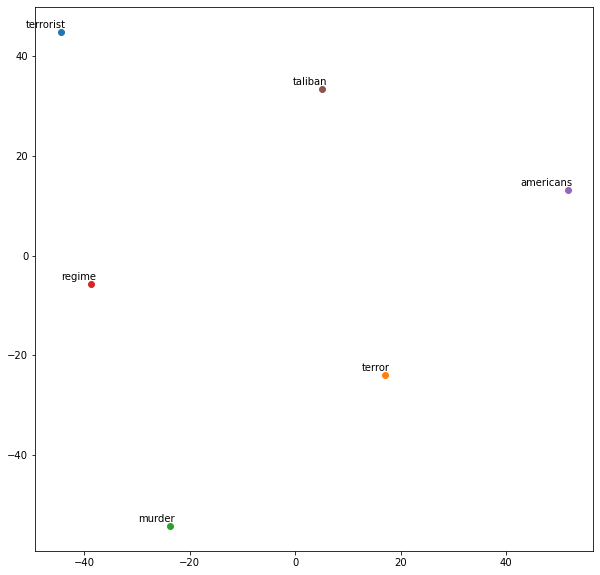

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model, set_array):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    print('creating tokens and labels')
#     for word in model.wv.key_to_index:
#         tokens.append(model.wv[word])
#         labels.append(word)
    
    set_array = [token.lower() for token in set_array]
    
    for word in set_array:
        if word in model.wv.index_to_key:
            tokens.append(model.wv[word])
            labels.append(word)
    
    
    print('building tsne model')
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    print('constructing graph')
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        
        if labels[i] in set_array:
            plt.annotate(labels[i],
                xy=(x[i], y[i]),
                xytext=(5, 2),
                textcoords='offset points',
                ha='right',
                va='bottom')
            
    plt.savefig('vector_distribution.png')
    plt.show()
    
terms = seed_terms + ingroups + outgroups
print(len(terms), 'terms')
tsne_plot(doc_array.model, terms)

True
creating tokens and labels
building tsne model
constructing graph


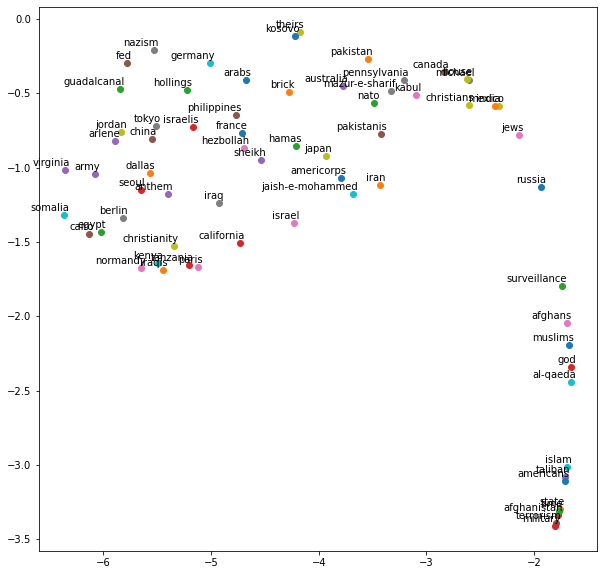

creating tokens and labels
building tsne model
constructing graph


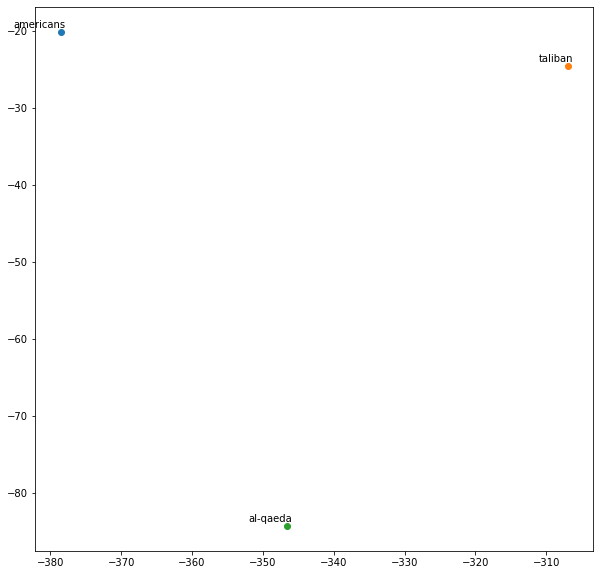

In [26]:
print('United States' in doc_array)
tsne_plot(doc_array.model, doc_array.group_ents)
tsne_plot(doc_array.model, ['United States', 'Americans', 'Taliban', 'al-qaeda'])

In [11]:
outgroups = ['Taliban', 'al Qaeda']
seed_terms = ['terrorist', 'terror', 'murder', 'regime']
    
def get_word_contexts(iterable, terms_of_interest, seed_terms):
    
    for sentence in iterable:
    
        for term in terms_of_interest:

            term = term.lower()

            if term in sentence:

                index = sentence.index(term)

                if index - 5 >= 0:
                    left = index - 5
                else:
                    left = 0

                if index + 5 <= len(sentence):
                    right = index + 5
                else:
                    right = len(sentence)
                    
                new_sent = [token for token in sentence[left : right]]
                
                for seed_term in seed_terms:
                    new_sent.insert(0, seed_term in new_sent)
                    break
                    
                yield new_sent
                
with pd.option_context('display.max_rows', 100, 'display.max_colwidth', None):
        
    display(pd.DataFrame(get_word_contexts(doc_array, outgroups, seed_terms)).fillna(value=''))

,0,1,2,3,4,5,6,7,8,9,10
0,False,al-qaeda,great,influence,afghanistan,support,taliban,regime,control,country,
1,False,large,source,humanitarian,aid,condemn,taliban,regime,,,
2,False,aid,abet,murder,taliban,regime,commit,murder,,,
3,False,tonight,united_states,make,following,demand,taliban,deliver,united_states,authority,leader
4,False,taliban,act,act,immediately,,,,,,
5,False,terrorism,training,camp,military,installation,taliban,regime,afghanistan,,
6,False,base,operation,attack,military,capability,taliban,regime,,,
7,False,more_than_two_week_ago,give,taliban,leader,series,clear,specific,,,
8,False,taliban,pay,price,,,,,,,
9,False,taliban,regime,bring,fear,misery,,,,,


In [12]:
terms_array = [outgroups, ingroups, seed_terms_bad]


for terms in terms_array:
    data = {}
    for term in terms:
        data[term] = {}
        data[term]['Occurence count'] = doc.text.lower().count(term.lower())
    
    display(pd.DataFrame(data))

,Taliban,al Qaeda
Occurence count,25,16


,United States,Americans
Occurence count,32,40


,enemy,terrorism,terrorist,terror,bad,evil,murder
Occurence count,18,20,107,196,1,33,29
